# Rappicard Test - Collections

### Import all libraries 

In [1]:
#pip install --upgrade --force-reinstall shapely
#pip install cufflinks


In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
from ipywidgets import interact
from chart_studio import plotly
import cufflinks as cf
import plotly.offline as pyoff
import plotly.graph_objs as go

cf.set_config_file(offline=False, world_readable=True)

cf.go_offline()

### EDA

In [4]:
df = pd.read_excel('BIQUIZ.xlsx')
df.shape

(12756, 12)

In [5]:
#Let's see the columns 
df['cnt'] = 1
df.columns

Index(['Numero_cliente', 'Fecha_Update', 'Estatus', 'Motivo', 'Tasa_Interes',
       'Importe', 'Id_product', 'CAT', 'TXN', 'CP', 'Puntuacion',
       'canal_venta', 'cnt'],
      dtype='object')

In [6]:
#Null values
df.isna().sum()

Numero_cliente        0
Fecha_Update          0
Estatus            4816
Motivo            10458
Tasa_Interes          0
Importe               0
Id_product            0
CAT                   0
TXN                   0
CP                    0
Puntuacion            0
canal_venta           0
cnt                   0
dtype: int64

In [7]:
#Total clients with a count distinct 
len(pd.unique(df['Numero_cliente']))

3341

In [8]:
#Average credit line
df_approv = df[['Estatus', 'Importe']][df.Estatus == 'APPROVED'].reset_index()
df_approv.Importe.mean()

14479.800664451826

In [9]:
#Check nulls for Status and no TXN
df_status_empty = df[(df.Estatus.isna())]
df_status_empty.TXN.value_counts().head(1)

0.0    1043
Name: TXN, dtype: int64

### General Overview:

* 3,341 Total Clients in this dataset


* $ 14,479 Average Credit Line at Booking

* 1,043 users users did not respond to any communication and that represents the 31.2% of the total clients

### Portfolio Status

In [10]:
#Check status distribution 
df_status = df['Estatus']
df_status.iplot(kind='hist', xTitle='Status', yTitle='Count', title='Status Distribution')

But the previous distribution is not showing us real data since it may be duplicate rows (3 or more rows for every client) 

The Process is the following:

    1. First Client Response to the communication
    2. Then we check the Risk Model to see if it is approved or not a CC to the client
    3. A CC is delievered in case of approval 
    
    
So now we have to see a distribution of Status for unique Clients...

In [11]:
#Let's see the uq Client distribution according to Status
df_status_clients = pd.DataFrame({ 
  'Clients' : [1043,793,1505]},
  index = ['No answer', 'Rejected', 'Approved'])


/usr/local/Cellar/ipython/7.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning:

Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.



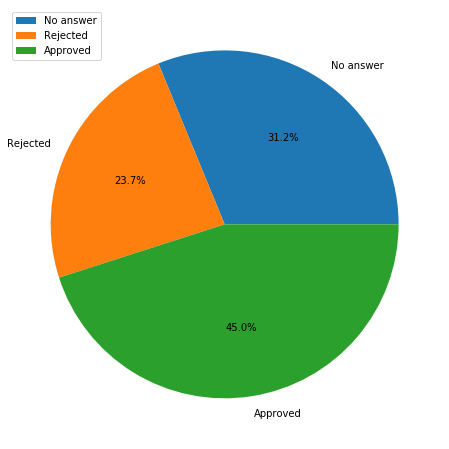

In [12]:
#Plot the distribution in a pie chart
#plt.pie(df_status_clients, y='Clients', figsize=(8, 8), autopct='%1.1f%%', startangle=0)

fig, ax = plt.subplots(figsize=(8, 8))

plt.pie(df_status_clients, labels=['No answer', 'Rejected', 'Approved'], autopct='%1.1f%%', 
     startangle=0)
plt.legend()
plt.show() 

That leaves us with the First Findings:
    * 45% of Approval Rate ( 1,505 Bookings ) 
    * 31.2% of Non responders 
    * 23.7% of Declines 
    
Let's do a deep dive on this...

In [13]:
#Pivot table to see the reason in case the CC application was approved or not 
df_approved = df[['Estatus', 'Motivo', 'Numero_cliente' ]]
df_approved.groupby(by=['Estatus', 'Motivo']).count()


Numero_cliente
Estatus  Motivo                 
APPROVED DIGITAL             459
         PLASTIC            1046
REJECTED EMPTY               164
         INCOME              163
         MOP                 232
         USAGE               234

* ### Approval Rate

45% of AR% is pretty good for international standards. 

30% of those approvals were only on Digital Channel, the rest of the CCs were sent physically. Why is this happening? I would also review the characteristics of this distribution. Some variables may help like age, geolocalization, time usage on mobile devices, etc

* ### Non Responders

31.2% are Non responders, people who didn't respond a communication through a specific channel. 

This represent an opportunity to contact them through a different channel...

* ### Declines

23.7% od Declines. Let's find it they are by Hard or Soft Declines...
 
* Income: 20.5%
* Empty: 20.7%
* MOP: 29.3%
* Usage: 29.5% 

Apparently only MOP may be considered as Hard Decline.
Are we good with our AR%? Or can we be more flexible with these rules to increase the number of applications sacrificing a little bit the AR%...

### Geolocalization

In [14]:
#Get the list of distinct CPs thanks to pgeocode 
import pgeocode
nomi = pgeocode.Nominatim('mx')
df_cp = df[(df.CP != 0 )]
list_cp = df_cp.CP.unique().tolist()
list_cps = [str(i) for i in list_cp]


In [15]:
#Get additionl info like City, lat, long since we have Postal Code
df_cp2 = nomi.query_postal_code(list_cps)
df_cp2.rename(columns={"postal_code": "CP"}, inplace=True)
df_cp2['CP'] = df_cp2.CP.astype(int)
df['CP'] = df.CP.astype(int)
df_cp2

,CP,country_code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
0,53100,MX,"Club Cuicacalli, Ciudad Satélite",México,15,Naucalpan de Juárez,57,Naucalpan de Juárez,9.0,19.5079,-99.2378,3
1,44100,MX,Guadalajara Centro,Jalisco,14,Guadalajara,39,Guadalajara,3.0,20.6734,-103.3584,1
2,11560,MX,Polanco V Sección,Distrito Federal,9,Miguel Hidalgo,16,Ciudad de México,11.0,19.4343,-99.1933,1
3,44620,MX,"Ayuntamiento, Chapultepec Country",Jalisco,14,Guadalajara,39,Guadalajara,3.0,20.6355,-103.3499,1
4,64000,MX,"Monterrey Centro, La Finca",Nuevo León,19,Monterrey,39,Monterrey,7.0,25.7334,-100.3321,1


In [16]:
#Merge original dataframe with the geolocalization df to have additional data 
df = df.merge(df_cp2, how='left', on='CP')
df.head()

,Numero_cliente,Fecha_Update,Estatus,Motivo,Tasa_Interes,Importe,Id_product,CAT,TXN,CP,...,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
0,3,"lunes, 11 de noviembre de 2019",NaN,NaN,0,0,8,0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12,"lunes, 11 de noviembre de 2019",NaN,NaN,0,0,2,0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,43,"lunes, 11 de noviembre de 2019",NaN,NaN,0,0,4,0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,57,"lunes, 11 de noviembre de 2019",NaN,NaN,0,0,1,0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,98,"lunes, 11 de noviembre de 2019",NaN,NaN,0,0,1,0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
#data[cols[0]].iplot(kind='hist', color= 'rgb(0,150,150)')
df.place_name.iplot(kind='hist', yTitle='CCs', 
                      title='Geolocalization of Bookings',color= 'rgb(0,150,150)')

In this excercise we see that there are predominat Bookings in big cities such as Edomex( Club Cuicacalli), Guadalajara, CDMX and Monterrey
 * Club Cuicacalli, Ciudad Satélite : 30.7% 
 * Guadalajara Centro : 28.5%
 * Polanco V Sección : 20.5%        
 * Monterrey Centro, La Finca : 10.4%     
 * Ayuntamiento, Chapultepec Country : 9.8%

### Channels

In [18]:
#Distribution of channels for all bookings
df_channel = df[['Estatus', 'canal_venta']][df.Estatus == 'APPROVED'].reset_index()
df_channel.canal_venta.value_counts(normalize=True)

Servicio al cliente    0.342857
Operaciones            0.328904
Marketing              0.328239
Name: canal_venta, dtype: float64

In [19]:
df_channel.canal_venta.iplot(kind='hist',  xTitle='Tenure Level', yTitle='Avg. Monthly Charge', 
                             title='Bookings through the door',color= 'rgb(255,124,0)')

In this excercise Bookings came basically one third on each channel: 

  * Servicio al cliente : 34.3%
  * Operaciones : 32.9%    
  * Marketing : 32.8%  
  
(Random sample did its job)

Only the sky is the limit to keep implementing strategies...

#### Done by 
### Jorge Miguel Mendoza Solano 